In [38]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D, LSTM ,Dropout
from keras.layers.convolutional import Conv1D, Conv2D
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile
import pandas as pd

In [39]:
c=mdb.get_files_for_instrument('flute')
for i in c:
    print(i)

C:\Users\absol\Documents\CECS551\Audio\JoelHelander_Definition\JoelHelander_Definition_STEMS\JoelHelander_Definition_STEM_09.wav
C:\Users\absol\Documents\CECS551\Audio\JoelHelander_Definition\JoelHelander_Definition_STEMS\JoelHelander_Definition_STEM_10.wav
C:\Users\absol\Documents\CECS551\Audio\MatthewEntwistle_AnEveningWithOliver\MatthewEntwistle_AnEveningWithOliver_STEMS\MatthewEntwistle_AnEveningWithOliver_STEM_12.wav
C:\Users\absol\Documents\CECS551\Audio\MatthewEntwistle_FairerHopes\MatthewEntwistle_FairerHopes_STEMS\MatthewEntwistle_FairerHopes_STEM_14.wav
C:\Users\absol\Documents\CECS551\Audio\MusicDelta_Beethoven\MusicDelta_Beethoven_STEMS\MusicDelta_Beethoven_STEM_06.wav
C:\Users\absol\Documents\CECS551\Audio\MusicDelta_Beethoven\MusicDelta_Beethoven_STEMS\MusicDelta_Beethoven_STEM_07.wav
C:\Users\absol\Documents\CECS551\Audio\MusicDelta_InTheHalloftheMountainKing\MusicDelta_InTheHalloftheMountainKing_STEMS\MusicDelta_InTheHalloftheMountainKing_STEM_07.wav
C:\Users\absol\Docu

# Load the mix

In [40]:
multitracks = mdb.load_multitracks(["Phoenix_ColliersDaughter", "Phoenix_ScotchMorris"])

In [41]:
mix = next(multitracks)

In [42]:
sample_rate, mix_audio = wavfile.read(mix.mix_path)
mix_audio = mix_audio.mean(1)
mix_audio = mix_audio[sample_rate*8:int(-sample_rate*1.5)]

In [43]:
samples_per_period = 256
overlap = int(samples_per_period/2)

In [44]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

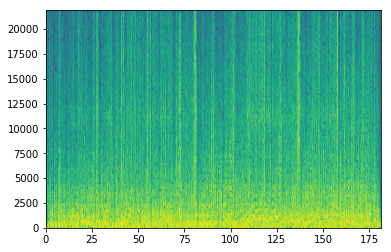

In [45]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))

# Load the Flute

In [46]:
mix.raw_instruments

['Main System',
 'Main System',
 'acoustic guitar',
 'electric bass',
 'flute',
 'violin']

In [47]:
flutes = mdb.get_files_for_instrument("flute", [mix])

In [48]:
flute = next(flutes)

In [49]:
sample_rate, flute_audio = wavfile.read(flute)
flute_audio = flute_audio.mean(1)
flute_audio = flute_audio[sample_rate*8:int(-sample_rate*1.5)]

In [50]:
freqs, times, s_flute = signal.stft(flute_audio, fs=sample_rate, nfft=samples_per_period, 
                                           noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_flute = s_flute[:-1,:]

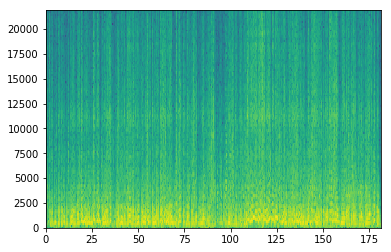

In [51]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_flute)))

## Create a mask for the flute

In [52]:
mask_flute = s_flute / (s_flute + s_mix + 1e-9)
print (mask_flute.shape)

(128, 62416)


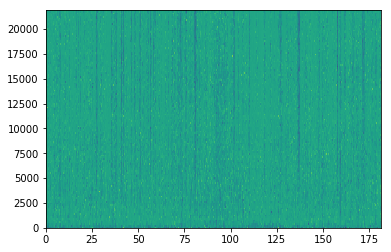

In [53]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(mask_flute)))

# Prepare the training data

In [54]:
num_test  = int((sample_rate * 10)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

60694 1722


In [55]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape


(60694, 128, 2)

In [56]:
flute_train = mask_flute.T[:num_train,:,np.newaxis]
flute_train = np.concatenate((flute_train.real, flute_train.imag), axis=-1)
flute_train.shape

(60694, 128, 2)

In [57]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(1722, 128, 2)

In [58]:
flute_test = mask_flute.T[-num_test:,:,np.newaxis]
flute_test = np.concatenate((flute_test.real, flute_test.imag), axis=-1)
flute_test.shape



(1722, 128, 2)

In [59]:
model = Sequential()

model.add(Conv1D(16, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_1"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_2"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_3"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_3"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_4"))
model.add(UpSampling1D(2, name="UpSampling_1"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_5"))
model.add(UpSampling1D(2, name="UpSampling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_6"))
model.add(UpSampling1D(2, name="UpSampling_3"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 128, 16)           80        
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 64, 16)            0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 64, 16)            528       
_________________________________________________________________
MaxPooling_2 (MaxPooling1D)  (None, 32, 16)            0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 32, 16)            528       
_________________________________________________________________
MaxPooling_3 (MaxPooling1D)  (None, 16, 16)            0         
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 16, 16)            528       
__________

In [70]:
regressor = Sequential() 
regressor.add(LSTM(units = 90, return_sequences=True, input_shape = mix_train.shape[1:])) 
regressor.add(Dropout(0.4))
    
regressor.add(LSTM(units = 90, return_sequences=True)) 
regressor.add(Dropout(0.4))
regressor.add(LSTM(units =90, return_sequences=True)) 
regressor.add(Dropout(0.4))
    
regressor.add(LSTM(units = 90, return_sequences=True)) 
regressor.add(Dropout(0.4))
     
regressor.add(LSTM(units = 90, return_sequences=True)) 
regressor.add(Dropout(0.4))
    
regressor.add(Dense(units=2))

regressor.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 128, 90)           33480     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128, 90)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 128, 90)           65160     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128, 90)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 128, 90)           65160     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128, 90)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 128, 90)           65160     
__________

In [71]:
regressor.compile('adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
history = regressor.fit(mix_train, flute_train, batch_size=200, epochs=10)

Epoch 1/10
32600/60694 [===============>..............] - ETA: 8:04 - loss: 0.6306 - acc: 0.8101

In [322]:
results = model.evaluate(mix_test, flute_test)

print(model.metrics_names)
print(results)

1722/1722 [==============================] - 1s 315us/step
['loss', 'acc']
[0.5187891838719482, 0.8179986929644275]


# Results

In [323]:
mask_prediction = model.predict(mix_test)
mask_prediction.shape

(1722, 128, 2)

In [324]:
mask_prediction = np.sqrt((mask_prediction**2).sum(-1)).T

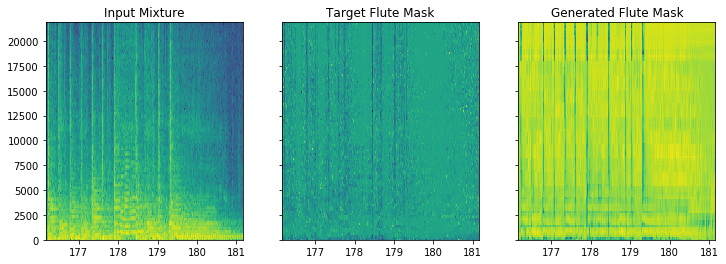

In [325]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target Flute Mask")
ax3.set_title("Generated Flute Mask")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(mask_flute[:,-num_test:])))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(mask_prediction))

In [326]:
target = s_mix[:,-num_test:] * mask_flute[:,-num_test:]

In [327]:
prediction = s_mix[:,-num_test:] * mask_prediction

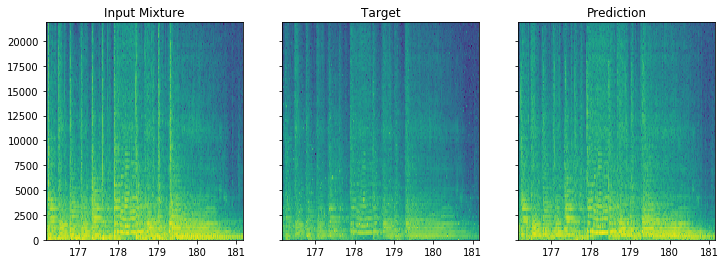

In [328]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [329]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)

In [330]:
wavfile.write("fcn_model_flute_prediction.wav", sample_rate, predicted_audio.astype(np.int16))

In [331]:
_, target_audio = signal.istft(target, fs=sample_rate)

In [332]:
wavfile.write("fcn_model_flute_target.wav", sample_rate, target_audio.astype(np.int16))

In [333]:
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

In [334]:
wavfile.write("fcn_model_original.wav", sample_rate, mix_audio.astype(np.int16))